PyMC Version: 5.25.1
ArviZ Version: 0.22.0
Data loaded successfully.
Sampling from the posterior distribution...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma]


d:\10academy\week_10_change_point_analysis_and_statistical_modelling_of_time_series_data\.venv\Lib\site-packages\ri
ch\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21094 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Model Summary:
              mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau        4519.95  3.22  4513.00  4525.00       0.11      0.1    803.72   
mu_before    21.50  0.28    20.99    22.04       0.00      0.0   5380.39   
mu_after     75.52  0.27    75.01    76.00       0.00      0.0   6175.23   
sigma        18.58  0.14    18.31    18.84       0.00      0.0   6141.58   

           ess_tail  r_hat  
tau          862.55    1.0  
mu_before   3100.34    1.0  
mu_after    3287.99    1.0  
sigma       3121.62    1.0  


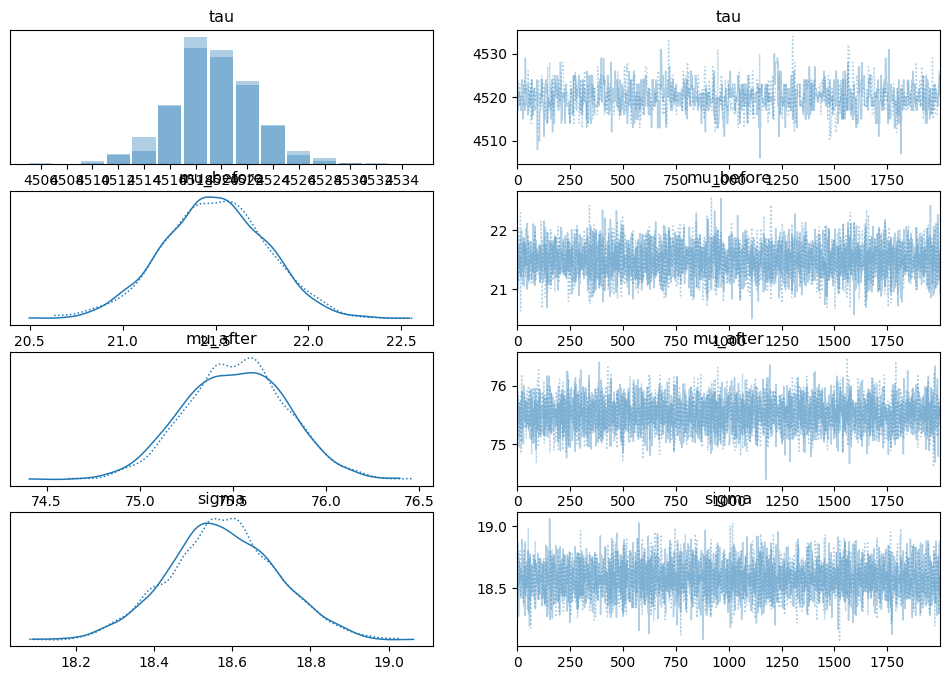

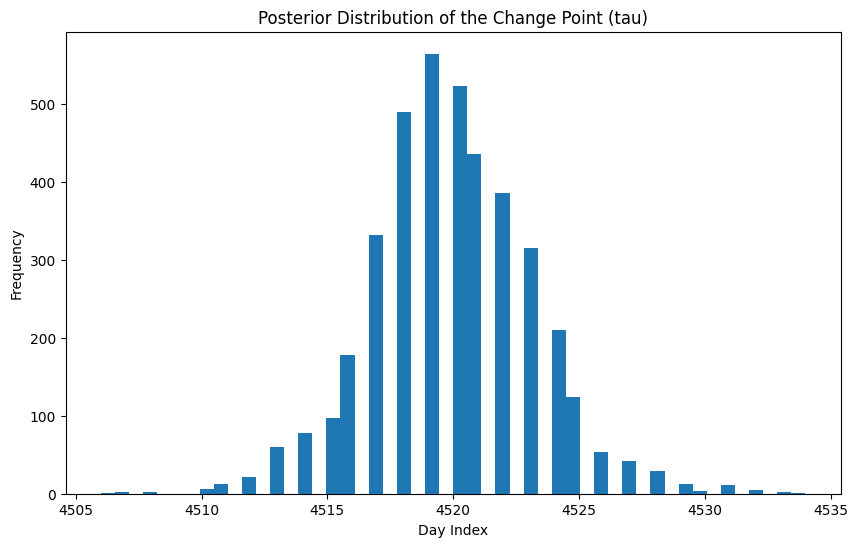

The most probable change point occurred on: 2005-02-22


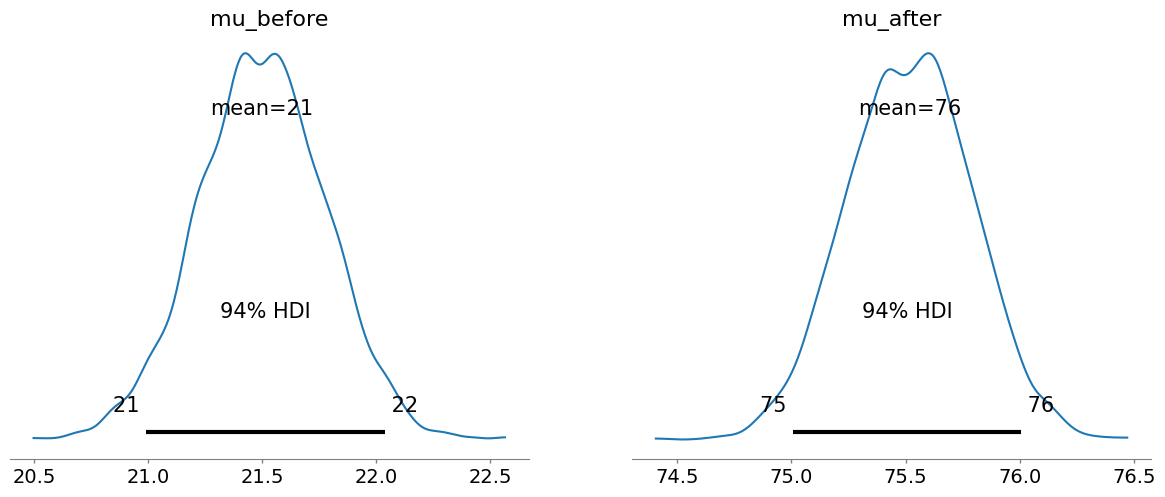


Most probable change point date:
2005-02-22 00:00:00

Compare this with your researched events to associate causes.


In [5]:
#Imports and Data Loading
# This cell sets up the environment and loads the necessary data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

print(f"PyMC Version: {pm.__version__}")
print(f"ArviZ Version: {az.__version__}")

# Load the cleaned data and events data from Task 1
try:
    brent_prices_df = pd.read_csv('../data/processed/brent_prices_cleaned.csv', index_col='Date', parse_dates=True)
    events_df = pd.read_csv('../data/processed/geopolitical_events.csv', parse_dates=['event_date'])
    
    # Extract the prices for modeling
    prices = brent_prices_df['Price'].values
    
    # The size of our dataset
    N = prices.shape[0]
    
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure that the data ingestion and event research scripts from Task 1 have been run.")
    print("Files 'brent_prices_cleaned.csv' and 'geopolitical_events.csv' are required in '../data/processed/'.")

#  Define and Run the Change Point Model
# This model assumes the mean of the prices changes at a specific, unknown point in time.
# The code has been updated to use the correct `sigma` keyword for PyMC v4+.

with pm.Model() as oil_price_model:
    
    # 1. Define the switch point (tau)
    # A discrete uniform prior over all possible days in the dataset.
    # We are modeling the *index* of the change point.
    tau = pm.DiscreteUniform('tau', lower=0, upper=N)
    
    # 2. Define the "Before" and "After" parameters (mean and standard deviation)
    # The mean prices before and after the change point
    mu_before = pm.Normal('mu_before', mu=prices.mean(), sigma=5)
    mu_after = pm.Normal('mu_after', mu=prices.mean(), sigma=5)
    
    # The standard deviation (volatility) of the prices
    # Use an Exponential distribution for standard deviation as it must be positive.
    sigma = pm.Exponential('sigma', lam=1)
    
    # 3. Use a switch function to select the correct mean based on tau
    # The `pm.math.switch` function will select mu_before if the index is < tau,
    # and mu_after if the index is >= tau.
    mu = pm.math.switch(tau >= np.arange(N), mu_before, mu_after)
    
    # 4. Define the likelihood: connect the model to the data
    # The observed prices are assumed to be normally distributed around the mean.
    observation = pm.Normal('observation', mu=mu, sigma=sigma, observed=prices)
    
    # 5. Run the sampler (MCMC simulation)
    # This will sample to find the posterior distributions of your parameters.
    # It might take a few minutes to run.
    print("Sampling from the posterior distribution...")
    idata = pm.sample(draws=2000, tune=1000, cores=2, return_inferencedata=True)

#  Interpreting the Model Output
# This cell visualizes the results of the MCMC sampling.

# Check for convergence and inspect the model
print("\nModel Summary:")
print(az.summary(idata, round_to=2))

# Plot the trace to check for sampling convergence
az.plot_trace(idata)
plt.show()

# Identify the change point (tau) by plotting its posterior distribution
tau_samples = idata.posterior['tau'].values.flatten()
plt.figure(figsize=(10, 6))
plt.hist(tau_samples, bins=50)
plt.title('Posterior Distribution of the Change Point (tau)')
plt.xlabel('Day Index')
plt.ylabel('Frequency')
plt.show()

# Get the most probable change point date
most_probable_tau = pd.Series(tau_samples).mode()[0]
change_point_date = brent_prices_df.index[most_probable_tau]
print(f"The most probable change point occurred on: {change_point_date.strftime('%Y-%m-%d')}")

# Visualize the impact (before vs. after prices)
az.plot_posterior(idata, var_names=['mu_before', 'mu_after'])
plt.show()

# Associate with events
# Compare the `change_point_date` with the `events_df` from your Task 1 research
# to formulate hypotheses about the cause of the change.
print("\nMost probable change point date:")
print(change_point_date)
print("\nCompare this with your researched events to associate causes.")